### ***Import Library that required for this Project ❤***

---



In [26]:
import string
import re
from tensorflow import keras
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

### ***❤ Reading the data that required for this Project ❤***
here, our data is text file of the german and English sentence's pairs.

---



In [27]:
def read_text(filename):
    # open
    file = open(filename, mode='rt', encoding='utf-8')
    # read all 
    text = file.read()
    file.close()
    return text

define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

---



In [28]:
def to_lines(text):
    sent = text.strip().split('\n')
    sent = [i.split('\t') for i in sent]
    return sent

extract deu.txt directory

---



In [29]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [30]:
deu_eng = deu_eng[:50000,:]

### ***❤ Text Pre-processing that required for this Project ❤***

---



Let's take a look at our data, then we will decide which pre-processing steps to adopt.

---



In [31]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom is still sitting.', 'Tom sitzt noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['Tom is still smoking.', 'Tom raucht immer noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['Tom is still talking.', 'Tom spricht noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

Remove punctuation

---

convert the lowercase

In [32]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['tom is still sitting', 'tom sitzt noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['tom is still smoking', 'tom raucht immer noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['tom is still talking', 'tom spricht noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

 **Text** to **Sequence** Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

---



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80f1955b50>,
      dtype=object)

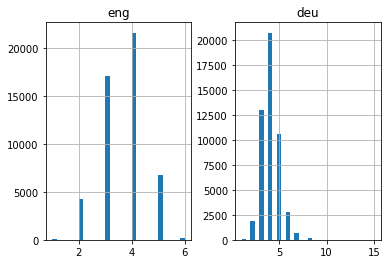

In [33]:
eng_l = []
deu_l = []
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30)

In [34]:
plt.show()

In [35]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

English Vocabulary Size: 6123
Deutch Vocabulary Size: 10081


### ***❤ Modelling the data that required for this Project ❤***

In [36]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [39]:
from tensorflow.keras import optimizers
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
filename = 'model.h1.02_03_2022'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 2.3886
Epoch 1: val_loss improved from inf to 2.35162, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 328s 5s/step - loss: 2.3886 - val_loss: 2.3516
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.2226
Epoch 2: val_loss improved from 2.35162 to 2.24659, saving model to model.h1.02_03_2022


In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: ignored

Make Predictions

In [44]:
model = load_model('model.h1.02_03_2022')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

pd.set_option('display.max_colwidth', 200)

AttributeError: ignored

In [ ]:
pred_df.head(15)
pred_df.tail(15)
pred_df.sample(15)